In [51]:
import numpy as np
from timeit import timeit as timeit
import os
import matplotlib.pyplot as plt
import subprocess
from joblib import Parallel, delayed
import multiprocessing 
import pandas as pd

# II - Formatage des données

## Conversion du format SNP vers SMC
Ici on convertit une matrice SNP en SMC. Dans ces deux fonctions on va juste gérer les colonnes ( données )

**15,1 Go sans compression vs 2,31 Go avec compression**

In [80]:
def SNPtoSMC(dist, SNP, POS):
    """
    dist : id de l'individu distingué
    SNP : matrice de SNPs
    POS : postions de la matrice de SNPs
    return : une matrice au format SMC
    """
    N = SNP.shape[0]
    M = POS.shape[0]
    N = N if N%2 == 0 else N - 1
    SNP = SNP[:N]
    assert dist < N/2
    
    dist *= 2
    SMC = np.zeros((2*M,4), dtype=int)
    SMC[:,-1] = N*np.ones(2*M, dtype=int) - 2
    SMC[:, 0] = np.ones(2*M, dtype=int)
    d = SNP[dist, :] + SNP[dist+1, :]
    u = np.sum(SNP, axis=0, dtype=int) - d
    SMC[1::2, 1:-1] = np.transpose([d, u]) 
    SMC[0::2, 0:-1] = np.transpose([POS - 1, np.zeros(M, dtype=int), np.zeros(M, dtype=int)])
    todelete = np.argwhere(POS <= 1).transpose()*2
    return np.delete(SMC, todelete, 0)

Ici on crée cette fonction pour corriger le bug des 0 dans les données

In [11]:
def loadfile(scenario, i, path="hdgp/scenario_",form=".npz"):
    file_name = path + scenario +"/hdgp_" + scenario + "_" + str(i) + form
    print(file_name)
    data = np.load(file_name)
    return data

In [12]:
data = loadfile("1576", 1)
print(data["SNP"].shape)

hdgp/scenario_1576/hdgp_1576_1.npz
(74, 654)


On crée une fonction pour crée le header du format smc

In [164]:
def header_smc(pid, dist, n_ind):
    """
    pid: id de la population considérée
    dist: individu distingué
    n_ind: nombre d'individus
    return: le header correspondant pour le format SMC
    """
    header = 'SMC++ {"version": "1.15.4.dev18+gca077da", "pids": ["'+ pid +'"], "undist": [['
    for i in range(n_ind):
        if(i != dist):
            indid = pid + str(i)
            header += '["' + indid + '", 0], ["' + indid + '", 1], '
    indid = pid + str(dist)
    header = header[:-2] + ']], "dist": [[["' + indid +'", 0], ["' + indid + '", 1]]]}'
    return header

In [165]:
## test sur un exemple simple
def test():
    snp = np.array([
    [0, 0, 1, 1],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1],
    ])
    pos = np.array([3, 5, 1, 10])
    print(SNPtoSMC(0, snp, pos))
    print(SNPtoSMC(1, snp, pos))
    print(SNPtoSMC(2, snp, pos))
test()

[[2 0 0 4]
 [0 0 2 4]
 [4 0 0 4]
 [0 0 1 4]
 [0 1 0 4]
 [9 0 0 4]
 [0 2 1 4]]
[[2 0 0 4]
 [0 2 0 4]
 [4 0 0 4]
 [0 0 1 4]
 [0 0 1 4]
 [9 0 0 4]
 [0 0 3 4]]
[[2 0 0 4]
 [0 0 2 4]
 [4 0 0 4]
 [0 1 0 4]
 [0 0 1 4]
 [9 0 0 4]
 [0 1 2 4]]


In [6]:
## mesure du temps prise par la fonction SNPtoSMC
n = 1000
data = loadfile(scenario="16844", i="5")
SMC = SNPtoSMC(0, data['SNP'], data['POS'])
print(SMC[:10])
time = timeit("SNPtoSMC(0, data['SNP'], data['POS'])", globals=globals(), number=n)/n
print(f"\nSNPtoSMC exec time {time:.5f}s")

assert SMC[:, 0].any() > 0

[[2328    0    0    8]
 [   1    1    4    8]
 [3344    0    0    8]
 [   1    1    5    8]
 [ 183    0    0    8]
 [   1    1    5    8]
 [2579    0    0    8]
 [   1    1    5    8]
 [  28    0    0    8]
 [   1    0    3    8]]

SNPtoSMC exec time 0.00054s


La première fonction sert à générer tous les fichiers SMC pour toutes données.
Alors que la seconde fonction c'est juste pour un scénario en particulier

In [7]:
def one_scenario(d="scenario_11687", save_dir="smc_files"):
    if save_dir not in os.listdir():
        os.mkdir(save_dir)
    for file in os.listdir("hdgp/" + d):
        # chargement des données
        data = np.load("hdgp/" + d + "/" + file)
        SNP, POS = data['SNP'], data['POS']
        # remplace tous les 0 de la matrice de positions par des 1
        POS[POS == 0] = 1 
        # on récupère le nombre d'individus (on le suppose pair)
        N = data['SNP'].shape[0]
        N = N if N%2 == 0 else N - 1
        # création du dossier du scénario
        scenario_dir = save_dir + "/" + d
        if d not in os.listdir(save_dir):
            os.mkdir(scenario_dir)
            
        for dist in range(0, int(N/2)):
            # pour chaque individu distingué, on crée un dossier qui contient les fichiers smc associés
            dist_dir = scenario_dir + "/" + "dist_" + str(dist)
            if "dist_" + str(dist) not in os.listdir(scenario_dir):
                os.mkdir(dist_dir)
            SMC = SNPtoSMC(dist, SNP, POS)
            filename = dist_dir + "/" + file + str(dist) + ".smc"
            header = header_smc("hdgp", dist, N)
            np.savetxt(filename , SMC, delimiter=' ', fmt = "%d", header=header)
            
def one_scenario_compressed (d="scenario_11687", save_dir="smc.gz_files"):
    if save_dir not in os.listdir():
        os.mkdir(save_dir)
    for file in os.listdir("hdgp/" + d):
        # chargement des données
        data = np.load("hdgp/" + d + "/" + file)
        SNP, POS = data['SNP'], data['POS']
        # remplace tous les 0 de la matrice de positions par des 1
        POS[POS == 0] = 1 
        # on récupère le nombre d'individus (on le suppose pair)
        N = data['SNP'].shape[0]
        N = N if N%2 == 0 else N - 1
        # création du dossier du scénario
        scenario_dir = save_dir + "/" + d
        if d not in os.listdir(save_dir):
            os.mkdir(scenario_dir)
            
        for dist in range(0, int(N/2)):
            # pour chaque individu distingué, on crée un dossier qui contient les fichiers smc associés
            dist_dir = scenario_dir + "/" + "dist_" + str(dist)
            if "dist_" + str(dist) not in os.listdir(scenario_dir):
                os.mkdir(dist_dir)
            SMC = SNPtoSMC(dist, SNP, POS)
            filename = dist_dir + "/" + file + str(dist) + ".smc.gz"
            header = header_smc("hdgp", dist, N)
            np.savetxt(filename , SMC, delimiter=' ', fmt = "%d", header=header)
            
def all_scenarios(multi_thread=False, compressed=True):
    if(multi_thread):
        num_cores = multiprocessing.cpu_count()
        if not compressed:
            Parallel(n_jobs=num_cores)(delayed(one_scenario)(d) for d in os.listdir("hdgp"))
        else: 
            Parallel(n_jobs=num_cores)(delayed(one_scenario_compressed)(d) for d in os.listdir("hdgp"))
    else:
        for d in os.listdir("hdgp"):
            if not compressed:
                one_scenario(d)
            else:
                one_scenario_compressed(d)


In [8]:
n = 3
time = timeit('one_scenario("scenario_6")', globals=globals(), number=n)/n
print(f"{time:.2f}s pour convertir tous les fichiers du scénario 6")
n = 1
#time = timeit("all_scenarios(True)", globals=globals(), number=n)/n
#print(f"{time:.2f}s pour convertir tous les scénarios")

KeyboardInterrupt: 

In [9]:
n = 3
#time = timeit('one_scenario("scenario_6")', globals=globals(), number=n)/n
#print(f"{tim:.2f}s pour convertir tous les fichiers du scénario 6")

**Le scenario 157 est assez lourd**

In [10]:
n = 3
#time = timeit('one_scenario("scenario_157")', globals=globals(), number=n)/n
#print(f"{time:.2f}s pour convertir tous les fichiers du scénario 157")

**Le scenario 565 est assez léger**

In [11]:
n = 3
#time = timeit('one_scenario("scenario_565")', globals=globals(), number=n)/n
#print(f"{time:.2f}s pour convertir tous les fichiers du scénario 565")

## Transformations de tous les scénarios au format smc compressé

In [12]:
n = 1
#time = timeit("all_scenarios(True)", globals=globals(), number=n)/n
#print(f"{time:.2f}s pour convertir tous les scénarios")

# III- Vérification

In [19]:
def loadfile_vcf(scenario, i, path="data_hdgp_2mb_vcf/hdgp/scenario_"):
    file_name = path + scenario +"/hdgp_" + scenario + "_" + str(i) + ".vcf"
    data = np.load(file_name)
    return data

In [20]:
scenario_dir = "data_hdgp_2mb_vcf/hdgp/scenario_"
scn = "0"
index = "5"

In [21]:
data = loadfile(scenario=scn, i=index, path= scenario_dir )
SMC = SNPtoSMC(0, data['SNP'], data['POS'])

**Ces commandes fonctionnent**

bgzip -c Adygei_hgdp_wgs.20190516.full.chr21.vcf > Adygei_hgdp_wgs.20190516.full.chr21.vcf.gz

tabix -p vcf Adygei_hgdp_wgs.20190516.full.chr21.vcf.gz

smc++ vcf2smc Adygei_hgdp_wgs.20190516.full.chr21.vcf.gz output.smc chr21 adygei:HGDP01396,HGDP01402

In [42]:
command = f'smc++ vcf2smc {scenario_dir}{scn}/hdgp_{scn}_{str(index)}.vcf  {scenario_dir}{scn}/hdgp_{scn}_{str(index)}_conv.smc tskit:tsk_0 ' 
print(f"running : {command}")
# plot the result
process = subprocess.Popen(command_plot, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = process.communicate()
print("\n",stdout, stderr)

running : smc++ vcf2smc data_hdgp_2mb_vcf/hdgp/scenario_0/hdgp_0_5.vcf  data_hdgp_2mb_vcf/hdgp/scenario_0/hdgp_0_5_conv.smc tskit:tsk_0 

 b'' b'usage: smc++ vcf2smc [-h] [-v] [--cores CORES] [-d sample_id sample_id]\n                     [--length LENGTH] [--ignore-missing] [--missing-cutoff c]\n                     [--mask MASK] [--drop-first-last]\n                     vcf.gz out[.gz] contig pop1 [pop2]\nsmc++ vcf2smc: error: the following arguments are required: pop1\n'


In [40]:
t = "tsk_0	tsk_1	tsk_2	tsk_3	tsk_4	tsk_5	tsk_6	tsk_7	tsk_8	tsk_9	tsk_10	tsk_11	tsk_12	tsk_13	tsk_14	tsk_15	tsk_16	tsk_17	tsk_18	tsk_19	tsk_20	tsk_21	tsk_22	tsk_23	tsk_24	tsk_25	tsk_26	tsk_27	tsk_28	tsk_29	tsk_30"

In [41]:
res = ""
for i in t:
    if i != "	":
        res+= i
    else:
        res+=","
        
print(res)

tsk_0,tsk_1,tsk_2,tsk_3,tsk_4,tsk_5,tsk_6,tsk_7,tsk_8,tsk_9,tsk_10,tsk_11,tsk_12,tsk_13,tsk_14,tsk_15,tsk_16,tsk_17,tsk_18,tsk_19,tsk_20,tsk_21,tsk_22,tsk_23,tsk_24,tsk_25,tsk_26,tsk_27,tsk_28,tsk_29,tsk_30


In [46]:
command1 = "bgzip -c data_hdgp_2mb_vcf/hdgp/scenario_0/hdgp_0_0.vcf > data_hdgp_2mb_vcf/hdgp/scenario_0/hdgp_0_0.gz"

In [47]:
command2 = "tabix -p vcf data_hdgp_2mb_vcf/hdgp/scenario_0/hdgp_0_0.gz"

In [48]:
command3 = "smc++ vcf2smc data_hdgp_2mb_vcf/hdgp/scenario_0/hdgp_0_0.gz output.smc 1 adygei:tsk_0,tsk_1,tsk_2,tsk_3,tsk_4,tsk_5,tsk_6,tsk_7,tsk_8,tsk_9,tsk_10,tsk_11,tsk_12,tsk_13,tsk_14,tsk_15,tsk_16,tsk_17,tsk_18,tsk_19,tsk_20,tsk_21,tsk_22,tsk_23,tsk_24,tsk_25,tsk_26,tsk_27,tsk_28,tsk_29,tsk_30"

In [64]:
process = subprocess.Popen(command1, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = process.communicate()
print("\n",stdout, stderr)


 b'' b''


**Ici commande qui pose problème**

In [65]:
process = subprocess.Popen(command2, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = process.communicate()
print("\n",stdout, stderr)


 b'' b'[E::hts_idx_check_range] Region 1165930710..1165930711 cannot be stored in a tbi index. Try using a csi index with min_shift = 14, n_lvls >= 6\ntbx_index_build failed: data_hdgp_2mb_vcf/hdgp/scenario_0/hdgp_0_0.gz\n'


**On peut résoudre le problème de la façon suivante**

In [66]:
command2_fix = "tabix -c data_hdgp_2mb_vcf/hdgp/scenario_0/hdgp_0_0.gz"
process = subprocess.Popen(command2_fix, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = process.communicate()
print("\n",stdout, stderr)


 b'' b'\nVersion: 1.10.2-3\nUsage:   tabix [OPTIONS] [FILE] [REGION [...]]\n\nIndexing Options:\n   -0, --zero-based           coordinates are zero-based\n   -b, --begin INT            column number for region start [4]\n   -c, --comment CHAR         skip comment lines starting with CHAR [null]\n   -C, --csi                  generate CSI index for VCF (default is TBI)\n   -e, --end INT              column number for region end (if no end, set INT to -b) [5]\n   -f, --force                overwrite existing index without asking\n   -m, --min-shift INT        set minimal interval size for CSI indices to 2^INT [14]\n   -p, --preset STR           gff, bed, sam, vcf\n   -s, --sequence INT         column number for sequence names (suppressed by -p) [1]\n   -S, --skip-lines INT       skip first INT lines [0]\n\nQuerying and other options:\n   -h, --print-header         print also the header lines\n   -H, --only-header          print only the header lines\n   -l, --list-chroms          list c

# III- Prédictions

In [6]:
def run_smc_estimate(scenario, out_dir="out", display=False):
    scenario_dir = f"smc.gz_files/{scenario}"
    scenario_out_dir = f"{out_dir}/{scenario}"
    if out_dir not in os.listdir():
        os.mkdir(out_dir)
    if scenario not in os.listdir(out_dir):
        os.mkdir(scenario_out_dir)
    for dist in os.listdir(scenario_dir):
        scenario_out_dist_dir = f"{scenario_out_dir}/{dist}"
        if dist not in os.listdir(scenario_out_dir):
            os.mkdir(scenario_out_dist_dir)
        command_estimate = f'smc++ estimate 1.45e-08 --knots 21 --timepoints 0 34483 -o {scenario_out_dist_dir} {scenario_dir}/{dist}/*.gz'
        command_plot = f'smc++ plot {scenario_out_dist_dir}/plot.png {scenario_out_dist_dir}/model.final.json' 
        print(f"running : {command_estimate}")
        # estimate
        process = subprocess.Popen(command_estimate, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
        stdout, stderr = process.communicate()
        if(display):
            print(stdout, stderr)
        # plot the result
        process = subprocess.Popen(command_plot, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        stdout, stderr = process.communicate()

### Utilie pour faire les fichiers dont on a besoin

In [33]:
n = 1
time = timeit('run_smc_estimate("scenario_11687", display=False)', globals=globals(), number=n)/n
print(f"{time:.2f}s smc")

running : smc++ estimate 1.45e-08 --knots 22 --timepoints 0 34483 -o out/scenario_11687/dist_0 smc.gz_files/scenario_11687/dist_0/*.gz
running : smc++ estimate 1.45e-08 --knots 22 --timepoints 0 34483 -o out/scenario_11687/dist_1 smc.gz_files/scenario_11687/dist_1/*.gz
running : smc++ estimate 1.45e-08 --knots 22 --timepoints 0 34483 -o out/scenario_11687/dist_2 smc.gz_files/scenario_11687/dist_2/*.gz
running : smc++ estimate 1.45e-08 --knots 22 --timepoints 0 34483 -o out/scenario_11687/dist_3 smc.gz_files/scenario_11687/dist_3/*.gz
running : smc++ estimate 1.45e-08 --knots 22 --timepoints 0 34483 -o out/scenario_11687/dist_4 smc.gz_files/scenario_11687/dist_4/*.gz
running : smc++ estimate 1.45e-08 --knots 22 --timepoints 0 34483 -o out/scenario_11687/dist_5 smc.gz_files/scenario_11687/dist_5/*.gz
1973.42s smc


In [1]:
def plot_csv_results(i,save_path):
    """
    i : numéro du scénario
    """
    fig, ax = plt.subplots(1, 1)
    results_deep = np.genfromtxt('hdgp_demo_parameters_subsample.csv',delimiter=',', dtype=int)
    X = results_deep[1,6:27]
    ids = np.argwhere(results_deep[:,0] == i)
    Y = results_deep[ids,27:].flatten()
    X2 = np.zeros(2*X.size, dtype=int)
    Y2 = np.zeros(2*Y.size, dtype=int)
    X2[1::2], X2[::2] = X, X
    Y2[1::2], Y2[::2] = Y, Y
    X2 = X2[1:]
    Y2 = Y2[:-1]
    ax.plot(X2, Y2, label=f"scénario_{i}")
    ax.set_yscale('log')
    ax.legend()
    plt.savefig(f'{save_path}/{i} .png')

FileNotFoundError: [Errno 2] No such file or directory: 'plot/11687 .png'

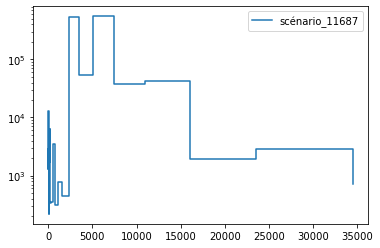

In [4]:
plot_csv_results(11687,'plot')

In [9]:
def run_smc_plot(scenario, out_dir="out", display=False):
    scenario_dir = f"smc_files/{scenario}"
    scenario_out_dir = f"{out_dir}/{scenario}"
    assert out_dir in os.listdir()
    assert scenario in os.listdir(out_dir)
    for dist in os.listdir(scenario_dir):
        scenario_out_dist_dir = f"{scenario_out_dir}/{dist}"
        assert dist in os.listdir(scenario_out_dir)
        command_plot = f'smc++ plot -c {scenario_out_dist_dir}/plot.png {scenario_out_dist_dir}/model.final.json' 
        print(f"running : {command_plot}")
        # plot the result
        process = subprocess.Popen(command_plot, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        stdout, stderr = process.communicate()

In [10]:
run_smc_plot("scenario_11687")

running : smc++ plot -c out/scenario_11687/dist_5/plot.png out/scenario_11687/dist_5/model.final.json
running : smc++ plot -c out/scenario_11687/dist_3/plot.png out/scenario_11687/dist_3/model.final.json
running : smc++ plot -c out/scenario_11687/dist_0/plot.png out/scenario_11687/dist_0/model.final.json
running : smc++ plot -c out/scenario_11687/dist_4/plot.png out/scenario_11687/dist_4/model.final.json
running : smc++ plot -c out/scenario_11687/dist_1/plot.png out/scenario_11687/dist_1/model.final.json
running : smc++ plot -c out/scenario_11687/dist_2/plot.png out/scenario_11687/dist_2/model.final.json


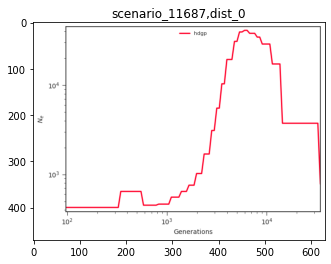

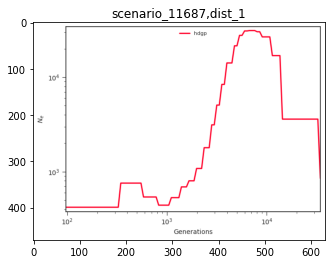

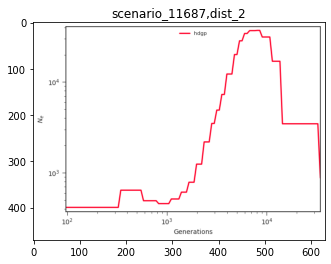

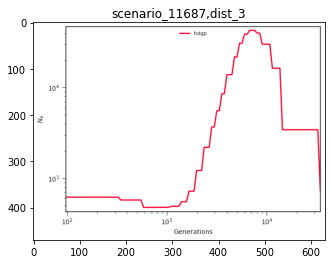

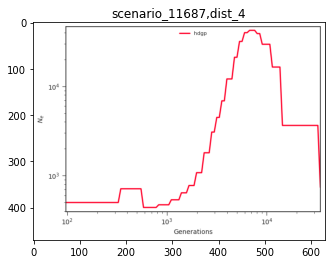

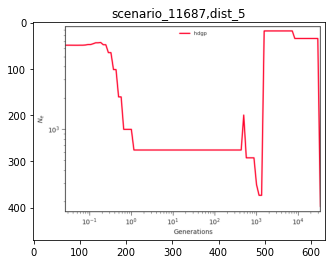

In [11]:
scenario = 11687
for dist in range(6):
    fig = plt.imread(f"out/scenario_{scenario}/dist_{dist}/plot.png")
    plt.title(f"scenario_{11687},dist_{dist}")
    plt.imshow(fig)
    plt.show()

## Je fais la moyenne des courbes sur les mêmes interballes de temps ici

In [13]:
dfs = [0]*6
for i in range(6):
    dfs[i] = pd.read_csv(f"out/scenario_11687/dist_{i}/plot.csv") 
    print(dfs[i])

    label             x            y plot_type  plot_num
0    hdgp      0.000000   426.689695      path         0
1    hdgp    107.223901   426.689695      path         0
2    hdgp    113.662709   426.689695      path         0
3    hdgp    120.488168   426.689695      path         0
4    hdgp    127.723496   426.689695      path         0
..    ...           ...          ...       ...       ...
96   hdgp  27308.600782  3740.915511      path         0
97   hdgp  28948.485459  3740.915511      path         0
98   hdgp  30686.845403  3740.915511      path         0
99   hdgp  32529.594065  3740.915511      path         0
100  hdgp  34483.000000   777.722134      path         0

[101 rows x 5 columns]
    label             x            y plot_type  plot_num
0    hdgp      0.000000   420.273314      path         0
1    hdgp    107.223901   420.273314      path         0
2    hdgp    113.662709   420.273314      path         0
3    hdgp    120.488168   420.273314      path         0
4    hd

In [16]:
def meanPlot(scenario):
    csv = pd.read_csv(f"out/scenario_{scenario}/dist_{0}/plot.csv") 
    y = csv['y'].to_numpy()

    fig, ax = plt.subplots(1, 1)
    ax.plot(csv['x'].to_numpy(), y, label=f"scénario_{scenario}.dist{0}")
    
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax.set_xlim(100,10e3+1000)
    ax.legend()


**On observe la même courbe faite à partir du csv que celle qui est générée, enfin plus ou moins**

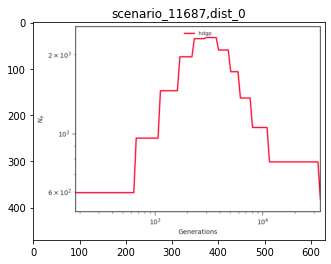

In [27]:
fig = plt.imread(f"out/scenario_{scenario}/dist_{0}/plot.png")
plt.title(f"scenario_{11687},dist_{0}")
plt.imshow(fig)
plt.show()

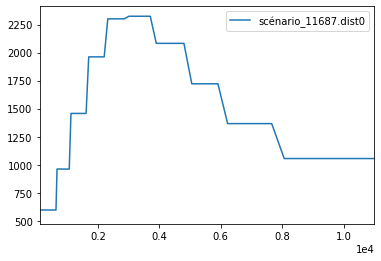

In [29]:
meanPlot(11687) 

In [133]:
def plotDist(scenario):
    csv = pd.read_csv(f"out/scenario_{scenario}/dist_{0}/plot.csv") 
    y = csv['y'].to_numpy()
    fig, ax = plt.subplots(1, 1, figsize=(15,15))
    ax.plot(csv['x'].to_numpy(),csv['y'].to_numpy(),label=f"scénario_{scenario}_dist_{0}")
    x = []
    for dist in range(1,6):
        csv = pd.read_csv(f"out/scenario_{scenario}/dist_{dist}/plot.csv") 
        y += csv['y'].to_numpy()
        ax.plot(csv['x'].to_numpy(),csv['y'].to_numpy(),label=f"scénario_{scenario}_dist_{dist}")

    y = y/5
    
    #fig, ax = plt.subplots(1, 1)
    #ax.plot(csv['x'].to_numpy(), y, label=f"scénario_{scenario} moyenne")
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax.set_xlim(0,10e3+1000)
    ax.legend()

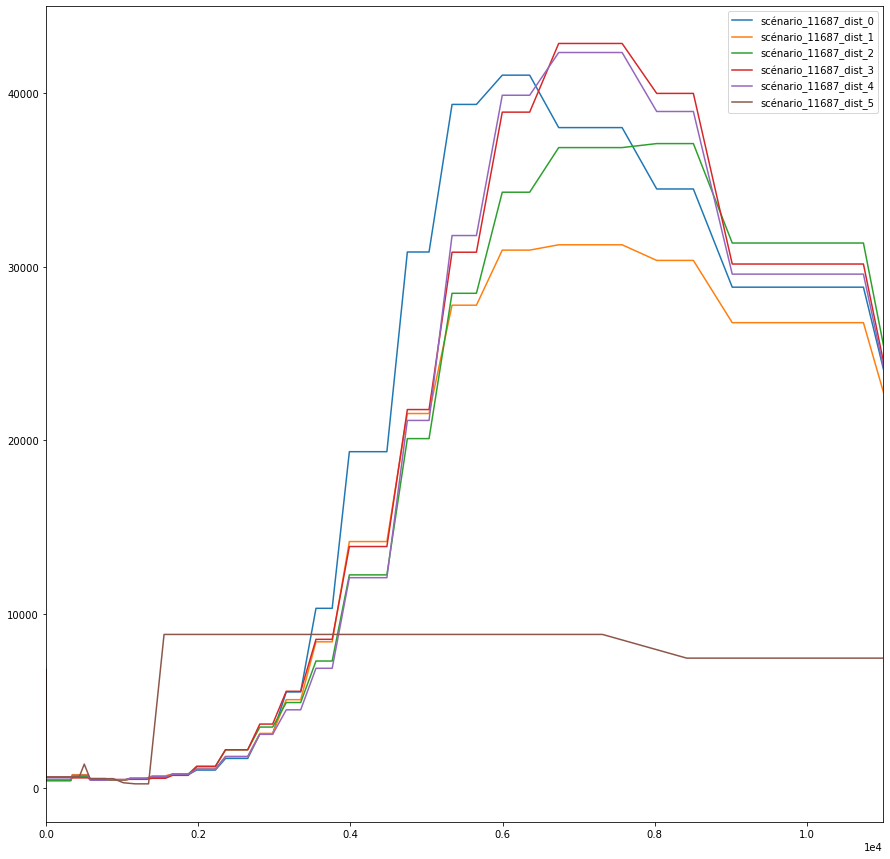

In [134]:
plotDist(11687)

In [178]:
def meanPlot(scenario):
    csv = pd.read_csv(f"out/scenario_{scenario}/dist_{0}/plot.csv") 
    x = csv['x'].to_numpy().tolist()
    
    
    # je construit le grand intervalle ici
    for dist in range(0,6):
        csv = pd.read_csv(f"out/scenario_{scenario}/dist_{dist}/plot.csv") 
        x_temp = csv['x'].to_numpy().tolist()
        
        for i in x_temp:
            if i not in x:
                x.append(i)
    x = np.array(x)
    x = np.sort(x)
    
    y = np.zeros(len(x))
    for dist in range(1,6):
        csv = pd.read_csv(f"out/scenario_{scenario}/dist_{dist}/plot.csv")
        
        y_res = complete(x,csv['x'].to_numpy(),csv['y'].to_numpy())
        y += y_res
        
        

    y = y/5
    
    fig, ax = plt.subplots(1, 1)
    ax.plot(x, y, label=f"scénario_{scenario} moyenne")
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax.set_xlim(0,10e3+1000)
    ax.legend()
    
    return x,y

    
# ici il faut faire attention aux résultats de cette fonction

def complete(x,x_v,y_v):
    y_res = np.zeros(len(x))
    
    compteur_x = 0
    compteur_y=0
    for val in x_v:
        if x[compteur_x] == val:
            y_res[compteur_x] = y_v[compteur_y]
            compteur_x +=1
            
            
        while  x[compteur_x] <= val:
            y_res[compteur_x] = y_v[compteur_y]
            compteur_x +=1
            if compteur_x  == len(x):
                break
        compteur_y +=1
        
        
    return y_res
            


In [179]:
complete( [1,2,3,4,5],[1,3,5],[10,11,215])

array([ 10.,  11.,  11., 215., 215.])

In [14]:
#meanPlot(11687)

## Partie Adygei

Dans cette partie, on va comparer le temps d'exécution et les résultats sur l'estimation smc, entre les fichiers de SNP et le fichier VCF.
Les fichiers SNPs et les VCFs représentent les mêmes données, sous deux formats différents.

On se concentre sur le chromosome21, avec 16 individus comme sample.

Voici les fichiers SNPs associées
```
npz_data_pop_ancestral_derived $ ls -l | grep chr21
-rw-r--r-- 1 jerome jerome  5665 Dec  1  2020 Adygei_chr21_1.npz
-rw-r--r-- 1 jerome jerome  6266 Dec  1  2020 Adygei_chr21_10.npz
-rw-r--r-- 1 jerome jerome  6071 Dec  1  2020 Adygei_chr21_11.npz
-rw-r--r-- 1 jerome jerome  3672 Dec  1  2020 Adygei_chr21_12.npz
-rw-r--r-- 1 jerome jerome  5833 Dec  1  2020 Adygei_chr21_13.npz
-rw-r--r-- 1 jerome jerome  4055 Dec  1  2020 Adygei_chr21_14.npz
-rw-r--r-- 1 jerome jerome  5206 Dec  1  2020 Adygei_chr21_15.npz
-rw-r--r-- 1 jerome jerome  7222 Dec  1  2020 Adygei_chr21_16.npz
-rw-r--r-- 1 jerome jerome  5802 Dec  1  2020 Adygei_chr21_2.npz
-rw-r--r-- 1 jerome jerome  6950 Dec  1  2020 Adygei_chr21_3.npz
-rw-r--r-- 1 jerome jerome  6251 Dec  1  2020 Adygei_chr21_4.npz
-rw-r--r-- 1 jerome jerome  6116 Dec  1  2020 Adygei_chr21_5.npz
-rw-r--r-- 1 jerome jerome  5602 Dec  1  2020 Adygei_chr21_6.npz
-rw-r--r-- 1 jerome jerome  5624 Dec  1  2020 Adygei_chr21_7.npz
-rw-r--r-- 1 jerome jerome  6579 Dec  1  2020 Adygei_chr21_8.npz
-rw-r--r-- 1 jerome jerome  6916 Dec  1  2020 Adygei_chr21_9.npz

```

Voici les 16 individus du fichier VCF
```
HGDP01396	HGDP01382	HGDP01403	HGDP01404	HGDP01402	HGDP01383	HGDP01401	HGDP01400	HGDP01384	HGDP01398	HGDP01397	HGDP01388	HGDP01387	HGDP01386	HGDP01385	HGDP01399
```

On commence par transformer le fichier vcf dans le format accepté par SMC :
Pour cela, il faut indexer le vcf et le fichier mask avec tabix

In [99]:
adygei_folder = "Adygei"
vcf_file = "Adygei_hgdp_wgs.20190516.full.chr21.vcf"
mask_file = "hgdp_wgs.20190516.mask.bed"
for file in [vcf_file, mask_file]:
    bgzip = f"bgzip {adygei_folder}/{file}"
    tabix = f"tabix {adygei_folder}/{file}.gz"
    process = subprocess.Popen(bgzip, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
    stdout, stderr = process.communicate()
    print(stdout, stderr)
    process = subprocess.Popen(tabix, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
    stdout, stderr = process.communicate()
    print(stdout, stderr)
vcf2smc = f"smc++ vcf2smc {adygei_folder}/{vcf_file}.gz {adygei_folder}/out.smc -m {adygei_folder}/hgdp_wgs.20190516.mask.bed.gz chr21 HGPD:HGDP01396,HGDP01382,HGDP01403,HGDP01404,HGDP01402,HGDP01383,HGDP01401,HGDP01400,HGDP01384,HGDP01398,HGDP01397,HGDP01388,HGDP01387,HGDP01386,HGDP01385,HGDP01399"
process = subprocess.Popen(vcf2smc, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
print(f"executing: {vcf2smc}")
stdout, stderr = process.communicate()
print(stdout, stderr)

 [bgzip] can't create Adygei/Adygei_hgdp_wgs.20190516.full.chr21.vcf.gz: File exists

 [tabix] the index file exists. Please use '-f' to overwrite.

 [bgzip] can't create Adygei/hgdp_wgs.20190516.mask.bed.gz: File exists

 [tabix] the index file exists. Please use '-f' to overwrite.

executing: smc++ vcf2smc Adygei/Adygei_hgdp_wgs.20190516.full.chr21.vcf.gz Adygei/out.smc -m Adygei/hgdp_wgs.20190516.mask.bed.gz chr21 HGPD:HGDP01396,HGDP01382,HGDP01403,HGDP01404,HGDP01402,HGDP01383,HGDP01401,HGDP01400,HGDP01384,HGDP01398,HGDP01397,HGDP01388,HGDP01387,HGDP01386,HGDP01385,HGDP01399
 956 smcpp.commands.vcf2smc INFO Population 1:
956 smcpp.commands.vcf2smc INFO Distinguished lineages: HGDP01396:0, HGDP01396:1
956 smcpp.commands.vcf2smc INFO Undistinguished lineages: HGDP01382:0, HGDP01382:1, HGDP01403:0, HGDP01403:1, HGDP01404:0, HGDP01404:1, HGDP01402:0, HGDP01402:1, HGDP01383:0, HGDP01383:1, HGDP01401:0, HGDP01401:1, HGDP01400:0, HGDP01400:1, HGDP01384:0, HGDP01384:1, HGDP01398:0, HGDP013

Puis on fait une estimation:

In [110]:
estimate = f"smc++ estimate 1e-10 {adygei_folder}/out.smc -o {adygei_folder}"
process = subprocess.Popen(estimate, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
#stdout, stderr = process.communicate()

On fait la même chose mais avec notre fonction adygei_folder

In [103]:
if "snptosmc" not in os.listdir(adygei_folder):
    os.mkdir(f"{adygei_folder}/snptosmc")
for i in range(1, 17):
    data = np.load(f"{adygei_folder}/snps/Adygei_chr21_{i}.npz")
    SNP = data["SNP"]
    POS = data["POS"]
    SMC = SNPtoSMC(1, SNP, POS)
    header = header_smc("adygei", 1, SNP.shape[0])
    np.savetxt(f"{adygei_folder}/snptosmc/chr21_{i}.smc" , SMC, delimiter=' ', fmt = "%d", header=header)

On fait l'estimation

In [111]:
estimate = f"smc++ estimate 1e-10 {adygei_folder}/snptosmc/*.smc -o {adygei_folder}/snptosmc"
process = subprocess.Popen(estimate, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
#stdout, stderr = process.communicate()

On affiche ces deux estimations

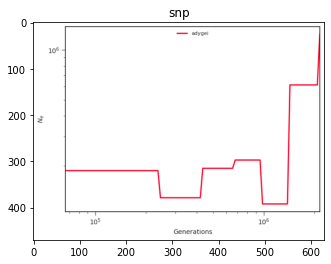

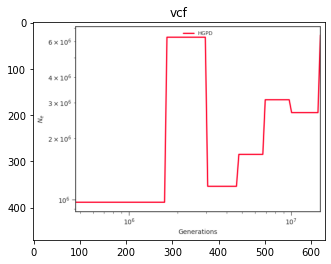

In [109]:
plot = f"smc++ plot -c {adygei_folder}/plot.png {adygei_folder}/model.final.json"
process = subprocess.Popen(plot, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
stdout, stderr = process.communicate()
print(stdout, stderr)
plot = f"smc++ plot -c {adygei_folder}/snptosmc/plot.png {adygei_folder}/snptosmc/model.final.json"
process = subprocess.Popen(plot, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
stdout, stderr = process.communicate()
print(stdout, stderr)
figsnp = plt.imread(f"{adygei_folder}/snptosmc/plot.png")
figvcf = plt.imread(f"{adygei_folder}/plot.png")
plt.title(f"snp")
plt.imshow(figsnp)
plt.show()
plt.title(f"vcf")
plt.imshow(figvcf)
plt.show()

# Partie comparaison VCF et SMC

In [81]:
file_directory = "data_hdgp_2mb_vcf/hdgp"
scenario = "0"
indiv = "7"
scenario_dir = f"{file_directory}/scenario_{scenario}"

## convertir le vcf en smc
file = f"{scenario_dir}/hdgp_{scenario}_{indiv}"
bgzip = f"bgzip {file}.vcf"
tabix = f"tabix -f {file}.vcf.gz"
process = subprocess.Popen(bgzip, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
stdout, stderr = process.communicate()
process = subprocess.Popen(tabix, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
stdout, stderr = process.communicate()
print(stdout, stderr)
vcf2smc = f"smc++ vcf2smc {file}.vcf.gz {file}.smc {int(scenario) + 1}  TSK:tsk_0,tsk_1,tsk_2,tsk_3,tsk_4,tsk_5,tsk_6,tsk_7,tsk_8,tsk_9,tsk_10,tsk_11,tsk_12,tsk_13,tsk_14,tsk_15,tsk_16,tsk_17,tsk_18,tsk_19,tsk_20,tsk_21,tsk_22,tsk_23,tsk_24,tsk_25,tsk_26,tsk_27,tsk_28,tsk_29,tsk_30"
process = subprocess.Popen(vcf2smc, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
#print(f"executing: {vcf2smc}")
stdout, stderr = process.communicate()
#print(stdout, stderr)

## convertir le snp en smc
data = np.load(f"{file}.npz")
SNP, POS = data["SNP"], data["POS"]

## récupérer les smc en mémoire
SMC_snp = SNPtoSMC(int(scenario), SNP, POS)
SMC_vcf = np.loadtxt(f"{file}.smc", dtype=int)
print(SMC_snp.shape, SMC_vcf.shape)
assert SMC_snp.shape == SMC_vcf.shape

n = 780
print(SMC_vcf[n:n+10], '\n')
print(SMC_snp[n:n+10], '\n')
print( np.argwhere((SMC_vcf - SMC_snp > 1)))
print( 100*(SMC_vcf - SMC_snp).sum() / SMC_vcf.size , "% de différence")

 
(6356, 4) (6356, 4)
[[  1   1  31  60]
 [231   0   0  60]
 [  1   1  29  60]
 [567   0   0  60]
 [  1   1  18  60]
 [173   0   0  60]
 [  1   1  31  60]
 [595   0   0  60]
 [  1   1  18  60]
 [230   0   0  60]] 

[[  1   1  31  60]
 [231   0   0  60]
 [  1   1  29  60]
 [566   0   0  60]
 [  1   1  18  60]
 [173   0   0  60]
 [  1   1  31  60]
 [595   0   0  60]
 [  1   1  18  60]
 [230   0   0  60]] 

[[2389    1]
 [2389    2]
 [2390    0]
 ...
 [6353    0]
 [6354    2]
 [6355    0]]
10.313089993706734 % de différence


In [83]:
command = f'gunzip {file}.vcf.gz; awk ' + "'{print $2}'" + f" {file}.vcf | tr '\n' ',' | sed -E 's/.*POS,//' | sed -E 's/.$//' "
process = subprocess.Popen(command, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
stdout, stderr = process.communicate()
tab = np.fromstring(stdout, sep=',', dtype=int)
tab_relative = np.zeros(len(tab), dtype=int)
tab_relative[0] = tab[0]
for i in range(1, len(tab)):
    tab_relative[i] = tab[i] - tab[i-1]
n = 10
print("vcf positions", tab_relative[:n])
print("snp positions", POS[:n])
print("Les 0 dans les positions vcf", np.argwhere(tab_relative == 0 ).transpose())
print("Les 0 dans les positions snp", np.argwhere(POS == 0 ).transpose())

vcf positions [ 582  102  167  479  600  746 2879  982  905  757]
snp positions [ 581  101  167  478  599  746 2879  982  904  757]
Les 0 dans les positions vcf [[1553 2059 2207 2702]]
Les 0 dans les positions snp [[ 201 1553 2059 2207 2413 2529 2702 2939 3145]]


# MSE

In [314]:
def loadCSV(scenario = 11687):
    trueData = np.genfromtxt('hdgp_demo_parameters_subsample.csv',delimiter=',', dtype=int)
    trueX = trueData[1,6:27]
    ids = np.argwhere(trueData[:,0] == scenario)
    trueY = trueData[ids,27:].flatten()
    
    dist = 0
    file = f'out/scenario_{scenario}/dist_{dist}/plot.csv'
    smcData = pd.read_csv(file)
    smcX = smcData['x'].to_numpy()
    smcY = smcData['y'].to_numpy()
    return trueX, trueY, smcX, smcY

In [461]:
def MSE(trueX, trueY, smcX, smcY):
    error = np.zeros(len(trueX))
    for i in range(1, len(trueX)):
        valid_ids = (smcX >= trueX[i - 1]) * (smcX <= trueX[i])
        if smcX[valid_ids].size > 1:
            weight = np.array(smcX[valid_ids], dtype=float)
            interval_size = max(weight) - min(weight)
            weight /= interval_size
            weight = weight[1:] - weight[:-1]
            assert abs(weight.sum()) - 1 < 1e-10
        else:
            weight = np.array([1])
            if (valid_ids == False).all():
                valid_ids = np.argwhere(smcX <= trueX[i])[-1]
            error[i] = np.dot(weight, np.array(smcY[valid_ids])) - trueY[i]
            continue
        error[i] = np.dot(weight, np.array(smcY[valid_ids])[:-1]) - trueY[i]
    mse = np.sum(error**2)/len(error)
    return mse, error

## Test de la fonction sur un exemple simple

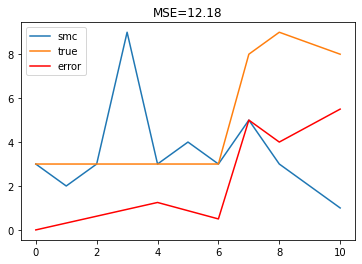

In [486]:
trueX = np.array([0, 4, 6, 7, 8, 10])
smcX = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
trueY = np.array([3, 3, 3, 8, 9, 8])
smcY = np.array([3, 2, 3, 9, 3, 4, 3, 5, 3, 2, 1])
mse, error = MSE(trueX, trueY, smcX, smcY)
fig, ax = plt.subplots(1, 1)
ax.plot(smcX, smcY, label='smc')
ax.plot(trueX, trueY, label='true')
ax.plot(trueX, abs(error), c='r', label='error')
ax.set_title(f'MSE={mse:.2f}')
ax.legend()

In [488]:
trueX, trueY, smcX, smcY = loadCSV()
mse, error = MSE(trueX, trueY, smcX, smcY)
print(mse)

28039400835.852093
